In [1]:
import torch

In [2]:
import numpy as np
import pandas as pd

In [3]:
#import torchvision

In [3]:
#import timm

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

In [5]:
# print all columns
pd.set_option('display.max_columns', None)

In [6]:
import os

In [7]:
import datetime

In [8]:
from scipy.interpolate import CubicSpline

In [9]:
import matplotlib.pyplot as plt

In [10]:
base_path = '/Volumes/Experiment Data/Sasha and Or/'

Load trajectory

In [12]:
# list of participants - ignore hidden files/folders (.DS_Store)
part_set = set([_dir for _dir in os.listdir(base_path) if not _dir.startswith(".")])

In [13]:
len(part_set)

38

In [14]:
exclude_set = set(['DL','OL','SM'])

In [15]:
part_list = list(part_set - exclude_set)

In [16]:
len(part_list)

35

In [17]:
def load_events(part):
    events_path = base_path+part+'/Events.csv'
    _events_df = pd.read_csv(events_path,on_bad_lines='warn')
    
    _simset = int(_events_df.columns[1].split('_')[1])
    
    _imgs = np.array([int(_events_df.loc[img][0]) for img in _events_df.index])
    
    _onsets = pd.Series([onset[0] for onset in _events_df.index],name='unity_time')
    _onsets = _onsets.apply(lambda x:x/1E7)
    # first line contains a timestamp but no "Looking" tag or eye data - ignore?
    #_events_onsets.insert(0,int(_events_df.columns[0]))
    print(str(len(_imgs)),'stimuli,',str(len(_onsets)),'events onsets' ,'- participant',part)
    # return pd.Series(_events_onsets,name='unity_time').apply(lambda x: x/1E7), _simset
    return _onsets, _simset, _imgs

In [ ]:
# ar_events_timedelta = ar_events_series - ar_events_series[0]

# ar_events_timedelta

# ar_events_timedelta = pd.to_timedelta(ar_events_timedelta,unit='S')

# ar_events_timedelta

In [17]:
# events_dict = {}
# for part in part_list:
    # try:
    #     onsets, simset, imgs = load_events(part)
    #     events_dict[part+'_events'] = onsets
    #     events_dict[part+'_simset'] = simset
    #     events_dict[part+'_imgs'] = imgs
    # except FileNotFoundError as e:
    #     print(e)

122 stimuli, 122 events onsets - participant AR
122 stimuli, 122 events onsets - participant DI
122 stimuli, 122 events onsets - participant DM
122 stimuli, 122 events onsets - participant IL
122 stimuli, 122 events onsets - participant IS
122 stimuli, 122 events onsets - participant MA
122 stimuli, 122 events onsets - participant NC
122 stimuli, 122 events onsets - participant NCH
122 stimuli, 122 events onsets - participant NH
122 stimuli, 122 events onsets - participant NT
124 stimuli, 124 events onsets - participant OA
122 stimuli, 122 events onsets - participant OB
122 stimuli, 122 events onsets - participant RB
122 stimuli, 122 events onsets - participant RN
122 stimuli, 122 events onsets - participant SG
122 stimuli, 122 events onsets - participant SHB
122 stimuli, 122 events onsets - participant SHM
122 stimuli, 122 events onsets - participant SSW
122 stimuli, 122 events onsets - participant TL
122 stimuli, 122 events onsets - participant VT
122 stimuli, 122 events onsets - par

In [ ]:
events_dict.keys()

columns - 
['confidence', 'GazeDirection_x', 'GazeDirection_y', 'GazeDirection_z',
       'GazeDistance', 'timestamp', 'norm_pos_x', 'norm_pos_y', 'EyeCenter0_x',
       'EyeCenter0_y', 'EyeCenter0_z', 'GazeNormal0_x', 'GazeNormal0_y',
       'GazeNormal0_z', 'EyeCenter1_x', 'EyeCenter1_y', 'EyeCenter1_z',
       'GazeNormal1_x', 'GazeNormal1_y', 'GazeNormal1_z', 'eyes_dir_hit_x',
       'eyes_dir_hit_y', 'eyes_dir_hit_z', 'eyes_to_surface_distance',
       'eyes_to_surface_angle', 'eyes_dir_name', 'unity_time',
       'TimeSinceStart', 'EyeID', 'Unnamed: 29']

In [ ]:
# Guess
# head_cols = ['Time',	'headx',	'heady',	'headz',	'head rot x',	head rot y	head rot z	head_dir_x	head_dir_y	head_dir_z]

In [ ]:
# def load_headDir(part):
#     head_path = base_path+part+'/position.csv'
#     _head_df = pd.read_csv(events_path,on_bad_lines='warn')
    
#     _cols = head_cols
#     # take intersection of head direction and gaze data?
    
#     return _head_df

In [15]:
# As per ofer rec to Sasha. R<>Sasha meet 7.6.22
gaze_cols = ['confidence', 'norm_pos_x', 'norm_pos_y', 'timestamp','unity_time', 'TimeSinceStart']

In [16]:
def load_binocular(part,cols=None):
    events_path = base_path+part+'/Gaze data.csv'
    _gaze_df = pd.read_csv(events_path,on_bad_lines='warn')
    
    _cols = cols if cols else _gaze_df.columns
    # Ofer 8.5.22 ID-ed 
    # hunch these should be reversed as per hist
    # _ODgaze_df = _gaze_df[_gaze_df['EyeID']=='Monocular_0']
    # _OSgaze_df = _gaze_df[_gaze_df['EyeID']=='Monocular_1']
    BINgaze_df = _gaze_df[_gaze_df['EyeID']=='Binocular'][_cols]
    BINgaze_df['unity_time'] = BINgaze_df['unity_time'].apply(lambda x: x/1E7)
    # _ODgaze_df['unity_time'] = _ODgaze_df['unity_time'].apply(lambda x: x/1E7)
    # _OSgaze_df['unity_time'] = _OSgaze_df['unity_time'].apply(lambda x: x/1E7)
    # return _ODgaze_df, _OSgaze_df
    return BINgaze_df

In [ ]:
# on gpu - slow
#gaze_dict = { _part : load_binocular(part=_part) for _part in part_list}

In [14]:
# test
ar_events_series, ar_simset, ar_imgs_arr = load_events('AR')

122 stimuli, 122 events onsets - participant AR


In [36]:
ar_events_series

0      4014.631096
1      4017.656451
2      4020.683983
3      4023.710307
4      4026.738614
          ...     
117    4368.490379
118    4371.517478
119    4374.545062
120    4377.560591
121    4380.588651
Name: unity_time, Length: 122, dtype: float64

In [17]:
ar_gaze_df = load_binocular('AR',gaze_cols)

In [18]:
ar_gaze_df.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart
0,0.918138,0.723382,0.448137,146.115616,4007.911429,146.2570
1,0.937311,0.701925,0.386575,146.121633,4007.911513,146.2571
6,0.956273,0.692180,0.373832,146.148917,4007.923613,146.2692
7,0.956273,0.689548,0.386851,146.152999,4007.923649,146.2692
8,0.872096,0.677746,0.328974,146.158153,4007.923692,146.2692


In [36]:
ar_gaze_df

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart
0,0.918138,0.723382,0.448137,146.115616,4007.911429,146.2570
1,0.937311,0.701925,0.386575,146.121633,4007.911513,146.2571
6,0.956273,0.692180,0.373832,146.148917,4007.923613,146.2692
7,0.956273,0.689548,0.386851,146.152999,4007.923649,146.2692
8,0.872096,0.677746,0.328974,146.158153,4007.923692,146.2692
...,...,...,...,...,...,...
56636,0.990000,0.370811,0.244052,528.740848,4390.521926,528.8675
56637,0.990000,0.367995,0.141275,528.744870,4390.534622,528.8802
56638,0.995000,0.360816,0.168879,528.750144,4390.534666,528.8802
56639,0.995000,0.352934,0.189367,528.755866,4390.534701,528.8802


In [19]:
# unity_time is the association key between ar_gaze_df and ar_events_series 
# onset time at ar_events_series[0] marks Beginning
ar_gaze_df['timedelta'] = ar_gaze_df['unity_time'] - ar_events_series[0]

In [20]:
# 125 hz
freq = 0.008

wait to trim end until after resample,reinterpolation but trim start from jump for resampling from onset

In [21]:
start_delta = 0.0 
# first 100 stimuli * 3 seconds each
# timedelta starts with 0 st second 300 is the right edge
# add one more time bracket for interpolation before trimming
end_delta = 300.0 

In [22]:
ar_gaze_df['timedelta'].head()

0   -6.719667
1   -6.719583
6   -6.707483
7   -6.707447
8   -6.707404
Name: timedelta, dtype: float64

In [23]:
ar_gaze_df['timedelta'].tail()

56636    375.890830
56637    375.903526
56638    375.903570
56639    375.903605
56640    375.903651
Name: timedelta, dtype: float64

In [24]:
# we want to resample at 120hz 
ar_gaze_df[(ar_gaze_df['timedelta'] > 0) & (ar_gaze_df['timedelta'] < 1)]

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta
888,1.000000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034
889,0.944890,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
890,0.944890,0.605414,-0.256802,152.890226,4014.659948,153.0055,0.028852
891,1.000000,0.601761,-0.253033,152.892312,4014.659989,153.0055,0.028893
892,1.000000,0.603854,-0.251132,152.896237,4014.660020,153.0056,0.028924
...,...,...,...,...,...,...,...
1026,0.982707,0.645056,0.699211,153.822617,4015.569642,153.9152,0.938546
1027,0.982707,0.644309,0.700609,153.827514,4015.569699,153.9153,0.938603
1028,0.951942,0.645132,0.702180,153.833066,4015.569733,153.9153,0.938637
1029,0.949832,0.643938,0.703098,153.837717,4015.579991,153.9256,0.948895


In [25]:
# cast as datetime for resampling, interpolation
ar_gaze_td_series = pd.to_datetime(ar_gaze_df['timedelta'],unit='s')

In [26]:
ar_gaze_df['timedelta_dt'] = ar_gaze_td_series

In [27]:
ar_gaze_df.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
0,0.918138,0.723382,0.448137,146.115616,4007.911429,146.2570,-6.719667,1969-12-31 23:59:53.280332600
1,0.937311,0.701925,0.386575,146.121633,4007.911513,146.2571,-6.719583,1969-12-31 23:59:53.280417300
6,0.956273,0.692180,0.373832,146.148917,4007.923613,146.2692,-6.707483,1969-12-31 23:59:53.292517100
7,0.956273,0.689548,0.386851,146.152999,4007.923649,146.2692,-6.707447,1969-12-31 23:59:53.292553000
8,0.872096,0.677746,0.328974,146.158153,4007.923692,146.2692,-6.707404,1969-12-31 23:59:53.292596000


In [30]:
ar_gaze_df

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
0,0.918138,0.723382,0.448137,146.115616,4007.911429,146.2570,-6.719667,1969-12-31 23:59:53.280332600
1,0.937311,0.701925,0.386575,146.121633,4007.911513,146.2571,-6.719583,1969-12-31 23:59:53.280417300
2,0.956273,0.692180,0.373832,146.148917,4007.923613,146.2692,-6.707483,1969-12-31 23:59:53.292517100
3,0.956273,0.689548,0.386851,146.152999,4007.923649,146.2692,-6.707447,1969-12-31 23:59:53.292553000
4,0.872096,0.677746,0.328974,146.158153,4007.923692,146.2692,-6.707404,1969-12-31 23:59:53.292596000
...,...,...,...,...,...,...,...,...
50274,0.990000,0.370811,0.244052,528.740848,4390.521926,528.8675,375.890830,1970-01-01 00:06:15.890829699
50275,0.990000,0.367995,0.141275,528.744870,4390.534622,528.8802,375.903526,1970-01-01 00:06:15.903525900
50276,0.995000,0.360816,0.168879,528.750144,4390.534666,528.8802,375.903570,1970-01-01 00:06:15.903570100
50277,0.995000,0.352934,0.189367,528.755866,4390.534701,528.8802,375.903605,1970-01-01 00:06:15.903604500


In [55]:
CubicSpline(ar_gaze_df['timedelta'],ar_gaze_df['norm_pos_x'],bc_type='periodic')

ValueError: The first and last `y` point along axis 0 must be identical (within machine precision) when bc_type='periodic'.

In [29]:
# unnecessary 
ar_gaze_df = ar_gaze_df.reset_index(drop=True)

In [46]:
ar_gaze_df.dtypes

confidence               float64
norm_pos_x               float64
norm_pos_y               float64
timestamp                float64
unity_time               float64
TimeSinceStart           float64
timedelta                float64
timedelta_dt      datetime64[ns]
dtype: object

In [48]:
# we want to resample at 120hz 
ar_gaze_df[(ar_gaze_df['timedelta'] >= 0) & (ar_gaze_df['timedelta'] <= 1)]

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
888,1.000000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034,1970-01-01 00:00:00.001033900
889,0.944890,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075,1970-01-01 00:00:00.001075300
890,0.944890,0.605414,-0.256802,152.890226,4014.659948,153.0055,0.028852,1970-01-01 00:00:00.028852399
891,1.000000,0.601761,-0.253033,152.892312,4014.659989,153.0055,0.028893,1970-01-01 00:00:00.028893199
892,1.000000,0.603854,-0.251132,152.896237,4014.660020,153.0056,0.028924,1970-01-01 00:00:00.028924100
...,...,...,...,...,...,...,...,...
1026,0.982707,0.645056,0.699211,153.822617,4015.569642,153.9152,0.938546,1970-01-01 00:00:00.938545699
1027,0.982707,0.644309,0.700609,153.827514,4015.569699,153.9153,0.938603,1970-01-01 00:00:00.938603199
1028,0.951942,0.645132,0.702180,153.833066,4015.569733,153.9153,0.938637,1970-01-01 00:00:00.938636599
1029,0.949832,0.643938,0.703098,153.837717,4015.579991,153.9256,0.948895,1970-01-01 00:00:00.948894900


In [34]:
# first data point from onset 
ar_gaze_sample = ar_gaze_df[ar_gaze_df['timedelta'] >= start_delta ][['timedelta_dt','norm_pos_x','norm_pos_y','timedelta']]

In [36]:
ar_gaze_sample = ar_gaze_sample.reset_index(drop=True)

In [37]:
ar_gaze_sample.head()

,timedelta_dt,norm_pos_x,norm_pos_y,timedelta
0,1970-01-01 00:00:00.001033900,0.603335,-0.251901,0.001034
1,1970-01-01 00:00:00.001075300,0.606151,-0.247742,0.001075
2,1970-01-01 00:00:00.028852399,0.605414,-0.256802,0.028852
3,1970-01-01 00:00:00.028893199,0.601761,-0.253033,0.028893
4,1970-01-01 00:00:00.028924100,0.603854,-0.251132,0.028924


In [224]:
_hz = 1/120
ar_gaze_sample.set_index('timedelta_dt').resample('{hz}S'.format(hz=_hz)).pad()

ValueError: Invalid frequency: 0.008333333333333333S

Resample with forward fill - missing much of the granularity

In [40]:
# freq = 125 HZ
# bfill handles first NaN but ffill assumes movement happens at next timepoint and interstitial time is horizontal
ar_gaze_resample = ar_gaze_sample.set_index('timedelta_dt').resample('{hz}S'.format(hz=freq)).ffill()

In [64]:
ar_gaze_resample.head()

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:00:00.000,0.603335,-0.251901,0.001034
1970-01-01 00:00:00.008,0.606151,-0.247742,0.001075
1970-01-01 00:00:00.016,0.606151,-0.247742,0.001075
1970-01-01 00:00:00.024,0.606151,-0.247742,0.001075
1970-01-01 00:00:00.032,0.597524,-0.247967,0.028954


In [65]:
ar_gaze_resample.tail()

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:06:15.864,0.403160,0.145998,372.294225
1970-01-01 00:06:15.872,0.403160,0.145998,372.294225
1970-01-01 00:06:15.880,0.403160,0.145998,372.294225
1970-01-01 00:06:15.888,0.403160,0.145998,372.294225
1970-01-01 00:06:15.896,0.370811,0.244052,375.890830


In [63]:
ar_gaze_sample.loc[ar_gaze_sample['timedelta']>0].head()

,timedelta_dt,norm_pos_x,norm_pos_y,timedelta
0,1970-01-01 00:00:00.001033900,0.603335,-0.251901,0.001034
1,1970-01-01 00:00:00.001075300,0.606151,-0.247742,0.001075
2,1970-01-01 00:00:00.028852399,0.605414,-0.256802,0.028852
3,1970-01-01 00:00:00.028893199,0.601761,-0.253033,0.028893
4,1970-01-01 00:00:00.028924100,0.603854,-0.251132,0.028924


In [62]:
ar_gaze_sample.tail()

,timedelta_dt,norm_pos_x,norm_pos_y,timedelta
49645,1970-01-01 00:06:15.890829699,0.370811,0.244052,375.890830
49646,1970-01-01 00:06:15.903525900,0.367995,0.141275,375.903526
49647,1970-01-01 00:06:15.903570100,0.360816,0.168879,375.903570
49648,1970-01-01 00:06:15.903604500,0.352934,0.189367,375.903605
49649,1970-01-01 00:06:15.903650799,0.363890,0.207194,375.903651


In [49]:
# if no data at the 0th time mark, will be na because ffill 
# fill onset gaze loc with "original" (closest) value 
if ar_gaze_resample.iloc[0].isna().all():
    # ar_gaze_sample.loc[ar_gaze_sample['timedelta']>0].index[0] should be equivalent to ar_gaze_sample.iloc[0] if reset index to start_delta ie timedelta >=0
    ar_gaze_resample.iloc[0] = ar_gaze_sample.iloc[0][ar_gaze_resample.columns]

(Cubic spline) interpolation between resampled points

In [68]:
# without ffill, index is destroyed and has nothing to be replaced/interpolated
# any interpolation method seems to fill the entire dataset with NaN -- unless maybe there is a datapoint which is exactly 
# can collect the resample as a series, merge with original and interpolate between points
# alternatively, (ensuing) forward fill. then [cubic spline] interpolate x,y
ar_gaze_NaNresample = ar_gaze_sample.set_index('timedelta_dt').resample('{hz}S'.format(hz=freq)).interpolate()

In [69]:
ar_gaze_sample

,timedelta_dt,norm_pos_x,norm_pos_y,timedelta
0,1970-01-01 00:00:00.001033900,0.603335,-0.251901,0.001034
1,1970-01-01 00:00:00.001075300,0.606151,-0.247742,0.001075
2,1970-01-01 00:00:00.028852399,0.605414,-0.256802,0.028852
3,1970-01-01 00:00:00.028893199,0.601761,-0.253033,0.028893
4,1970-01-01 00:00:00.028924100,0.603854,-0.251132,0.028924
...,...,...,...,...
49645,1970-01-01 00:06:15.890829699,0.370811,0.244052,375.890830
49646,1970-01-01 00:06:15.903525900,0.367995,0.141275,375.903526
49647,1970-01-01 00:06:15.903570100,0.360816,0.168879,375.903570
49648,1970-01-01 00:06:15.903604500,0.352934,0.189367,375.903605


In [70]:
ar_gaze_NaNresample

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:00:00.000,NaN,NaN,NaN
1970-01-01 00:00:00.008,NaN,NaN,NaN
1970-01-01 00:00:00.016,NaN,NaN,NaN
1970-01-01 00:00:00.024,NaN,NaN,NaN
1970-01-01 00:00:00.032,NaN,NaN,NaN
...,...,...,...
1970-01-01 00:06:15.864,NaN,NaN,NaN
1970-01-01 00:06:15.872,NaN,NaN,NaN
1970-01-01 00:06:15.880,NaN,NaN,NaN


In [71]:
# should be zero overlap between timestamps since original report is to nanosecond and resampling is by the millisecond

In [79]:
ar_gaze_sample = ar_gaze_sample.set_index('timedelta_dt')

In [85]:
ar_gaze_sample.columns == ar_gaze_NaNresample.columns

array([ True,  True,  True])

In [89]:
ar_gaze_resampledCat_df = pd.concat([ar_gaze_NaNresample,ar_gaze_sample])

In [114]:
# concats back to back
ar_gaze_resampledCat_df.head()

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:00:00.000,NaN,NaN,NaN
1970-01-01 00:00:00.008,NaN,NaN,NaN
1970-01-01 00:00:00.016,NaN,NaN,NaN
1970-01-01 00:00:00.024,NaN,NaN,NaN
1970-01-01 00:00:00.032,NaN,NaN,NaN


In [115]:
ar_gaze_resampledCat_df.tail()

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:06:15.890829699,0.370811,0.244052,375.890830
1970-01-01 00:06:15.903525900,0.367995,0.141275,375.903526
1970-01-01 00:06:15.903570100,0.360816,0.168879,375.903570
1970-01-01 00:06:15.903604500,0.352934,0.189367,375.903605
1970-01-01 00:06:15.903650799,0.363890,0.207194,375.903651


In [92]:
# intersperse time stamps
ar_gaze_resampledInterspersed_df = ar_gaze_resampledCat_df.sort_values(by='timedelta_dt')

In [93]:
ar_gaze_resampledInterspersed_df.head()

,norm_pos_x,norm_pos_y,timedelta
timedelta_dt,,,
1970-01-01 00:00:00.000000000,NaN,NaN,NaN
1970-01-01 00:00:00.001033900,0.603335,-0.251901,0.001034
1970-01-01 00:00:00.001075300,0.606151,-0.247742,0.001075
1970-01-01 00:00:00.008000000,NaN,NaN,NaN
1970-01-01 00:00:00.016000000,NaN,NaN,NaN


In [96]:
ar_gaze_cs_df = ar_gaze_resampledInterspersed_df[['norm_pos_x','norm_pos_y']].interpolate(method='cubicspline')

In [97]:
ar_gaze_cs_df.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000000000,NaN,NaN
1970-01-01 00:00:00.001033900,0.603335,-0.251901
1970-01-01 00:00:00.001075300,0.606151,-0.247742
1970-01-01 00:00:00.008000000,1.075943,0.005425
1970-01-01 00:00:00.016000000,1.408222,-0.321605


In [128]:
# take only the resampled time rows
ar_gaze_cs_resampled_df = ar_gaze_cs_df.loc[ar_gaze_NaNresample.index]

In [129]:
ar_gaze_cs_resampled_df.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,NaN,NaN
1970-01-01 00:00:00.008,1.075943,0.005425
1970-01-01 00:00:00.016,1.408222,-0.321605
1970-01-01 00:00:00.024,1.174222,-0.532017
1970-01-01 00:00:00.032,-0.170017,0.106299


In [132]:
# if no data at the 0th time mark, will be na because ffill 
# fill onset gaze loc with "original" (closest) value 
if ar_gaze_cs_resampled_df.iloc[0].isna().all():
    # ar_gaze_sample.loc[ar_gaze_sample['timedelta']>0].index[0] should be equivalent to ar_gaze_sample.iloc[0] if reset index to start_delta ie timedelta >=0
    ar_gaze_cs_resampled_df.iloc[0] = ar_gaze_sample.iloc[0][ar_gaze_cs_resampled_df.columns]

In [133]:
ar_gaze_cs_resampled_df.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,0.603335,-0.251901
1970-01-01 00:00:00.008,1.075943,0.005425
1970-01-01 00:00:00.016,1.408222,-0.321605
1970-01-01 00:00:00.024,1.174222,-0.532017
1970-01-01 00:00:00.032,-0.170017,0.106299


In [138]:
ar_gaze_input_df = ar_gaze_cs_resampled_df[ar_gaze_cs_resampled_df.index.minute < 6]

In [139]:
ar_gaze_input_df

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,0.603335,-0.251901
1970-01-01 00:00:00.008,1.075943,0.005425
1970-01-01 00:00:00.016,1.408222,-0.321605
1970-01-01 00:00:00.024,1.174222,-0.532017
1970-01-01 00:00:00.032,-0.170017,0.106299
...,...,...
1970-01-01 00:05:59.960,0.535993,-0.276614
1970-01-01 00:05:59.968,0.464119,-0.307525
1970-01-01 00:05:59.976,0.652363,-0.079985


In [143]:
freq

0.008

In [154]:
# try to redo timedelta with time
from datetime import datetime

In [160]:
# ar_gaze_cs_resampled_df[ar_gaze_cs_resampled_df.index.minute < 6]
# keep the right fencepost
ar_gaze_input_df = ar_gaze_cs_resampled_df[(ar_gaze_cs_resampled_df.index <= datetime(year=1970,month=1,day=1,minute=6,second=0))  ]

In [174]:
ar_gaze_input_df.shape

(45001, 2)

In [175]:
torch.tensor(ar_gaze_input_df[['norm_pos_x','norm_pos_y']].values).size()

torch.Size([45001, 2])

In [176]:
ar_gaze_input_tensor = torch.tensor(ar_gaze_input_df[['norm_pos_x','norm_pos_y']].values)

Syclops sandbox

In [180]:
import torch.nn as nn

In [178]:
max_depth = 128

In [185]:
elu = nn.ELU()

In [181]:
conv_depth_array = np.linspace(9,max_depth, 6).astype(int)

In [182]:
conv_depth_array

array([  9,  32,  56,  80, 104, 128])

In [183]:
actions_conv1 = nn.Conv1d(conv_depth_array[0],conv_depth_array[1],5, stride = 3)

In [184]:
actions_conv1

Conv1d(9, 32, kernel_size=(5,), stride=(3,))

Events

In [29]:
ar_simset

12

In [41]:
ar_imgs_arr

array([50, 82, 78, 71, 97, 86,  7, 64, 51, 99, 58, 44, 41, 85, 73, 12, 95,
       66, 15, 83, 87, 23, 31,  4, 54, 29, 16, 96, 92, 56, 70, 24, 38, 89,
       25, 88,  1, 49, 34, 19, 94, 62, 28, 75, 67, 81, 36, 46, 69, 11, 55,
       84,  2, 47, 53, 20, 48, 91, 35, 32, 93,  5, 33, 37, 60, 40, 77, 74,
       52,  0, 63, 72, 27, 80, 68, 22, 10,  8,  6,  3, 98, 76, 65, 79, 21,
       30,  9, 57, 59, 42, 18, 90, 39, 26, 13, 45, 17, 61, 43, 14, 73, 97,
       20, 93, 35, 95, 97, 23, 92, 71, 10, 85, 55,  0,  1, 33, 60, 40, 99,
       67, 31, 24])

In [42]:
ar_events_series

0      4014.631096
1      4017.656451
2      4020.683983
3      4023.710307
4      4026.738614
          ...     
117    4368.490379
118    4371.517478
119    4374.545062
120    4377.560591
121    4380.588651
Name: unity_time, Length: 122, dtype: float64

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [16]:
def decode_image_from_simset_and_label(simset,label):
    return x_train[np.where(y_train==label)[0][simset-1]]

In [17]:
img = decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[0])

In [24]:
img.shape

(32, 32, 3)

In [30]:
torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1])).shape

torch.Size([32, 32, 3])

In [56]:
imgs = torch.stack([torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[:5])),torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1]))])

NameError: name 'decode_image_from_simset_and_label' is not defined

In [38]:
imgs.shape

torch.Size([2, 32, 32, 3])

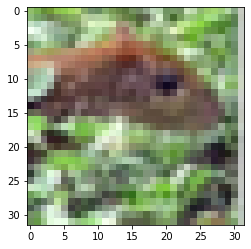

In [39]:
plt.imshow(img)

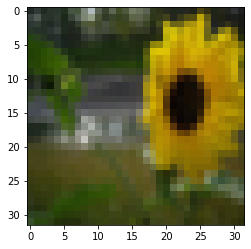

In [42]:
plt.imshow(imgs[1])

In [20]:
cifar_vit = timm.create_model('vit_base_patch16_224_miil_in21k', pretrained=True)

In [ ]:
mixer_b16_224_in21k

In [44]:
cifar_vit.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,)

In [43]:
cifar_vit(imgs)

AssertionError: Input image height (32) doesn't match model (224).

In [45]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv